*Erik J. Bekkers and Maxime W. Lafarge, Eindhoven University of Technology, the Netherlands*

*8 June 2018*

***

*This DEMO was tested on a laptop with*:
- *Windows as OS*
- *Jupyter Notebook (version 5.5.0)*
- *Python (version 3.5.5)*
- *TensorFlow-GPU (versions 1.1 and higher)*
- *An NVIDIA Quadro M1000M GPU*
- *The following additional libraries installed for this demo to run: sklearn, scipy, and matplotlib*

## Load the libraries

In [1]:
# Impor tensorflow and numpy
import tensorflow as tf
import numpy as np
import math as m
import time
# For validation
from sklearn.metrics import confusion_matrix
import itertools

# For plotting
from matplotlib import pyplot as plt

# Add the library to the system path
import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

# Import the library
import se2cnn.layers

# Build network

In [2]:
graph = tf.Graph()
graph.as_default()
tf.reset_default_graph()

In [3]:
Ntheta = 8 # Kernel size in angular direction
Nxy=5      # Kernel size in spatial direction
Nc_in = Nc_input = 5

In [4]:
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,9,9,Nc_input] )
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,] )

In [5]:
tensor_in = inputs_ph

In [6]:
## Settings
Nc_out = 3

## Perform lifting convolution
# The kernels used in the lifting layer
lifting_kernels = tf.get_variable(
                    'kernel_1', 
                    [Nxy,Nxy,Nc_in,Nc_out],
                    initializer=tf.random_normal_initializer())
# Lifting layer
tensor_lifted, lifting_kernels_formatted = se2cnn.layers.z2_se2n(
                        input_tensor = tensor_in,
                        kernel = lifting_kernels,
                        orientations_nb = Ntheta,diskMask=False)

Nc_in = Nc_out
tensor_in = tensor_lifted

Z2-SE2N BASE KERNEL SHAPE: (5, 5, 5, 3)
Z2-SE2N ROTATED KERNEL SET SHAPE: (8, 5, 5, 5, 3)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 5, 5, 8, 3)


In [7]:
## Settings
Nc_out = 5

## Perform group convolution
# The kernels used in the group convolution layer
gconv_kernels = tf.get_variable(
                    'kernel_2', 
                    [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                    initializer=tf.random_normal_initializer())
# The group convolution layer
tensor_lifted_2, gconv_kernels_formatted = se2cnn.layers.se2n_se2n(
                        input_tensor = tensor_in,
                        kernel = gconv_kernels,diskMask=False)

SE2N-SE2N BASE KERNEL SHAPE: (5, 5, 8, 3, 5)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (8, 5, 5, 8, 3, 5)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 1, 1, 8, 5)


***
# Test covariance

## Preparations

### Begin session

In [8]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

### Random 2D input signal

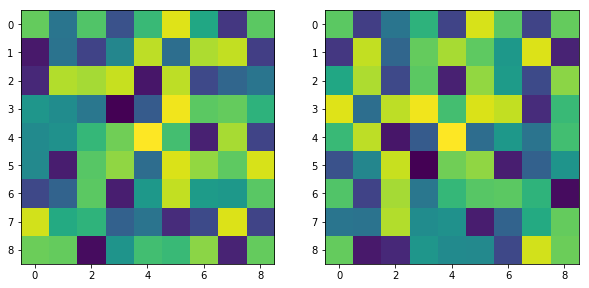

In [9]:
random_input = np.random.rand(1,9,9,Nc_input)
# And a 90 degree counter clock-wise rotated version
random_input_90 = np.transpose(np.flip(random_input,2),[0,2,1,3])

#Plot
f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(random_input[0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(random_input_90[0,:,:,0])
plt.show()

### Evaluate network

In [10]:
t_lifted,t_lifted_2,lifting_k,gconv_k = session.run(
                                [tensor_lifted,tensor_lifted_2,lifting_kernels_formatted,gconv_kernels_formatted],
                                feed_dict = {inputs_ph:random_input})

t_lifted_90, t_lifted_2_90 = session.run(
                                [tensor_lifted,tensor_lifted_2],
                                feed_dict = {inputs_ph:random_input_90})

## Check the kernels

### The rotated set of a lifting kernel

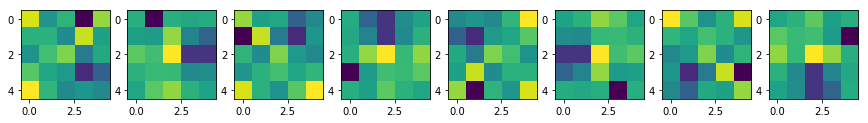

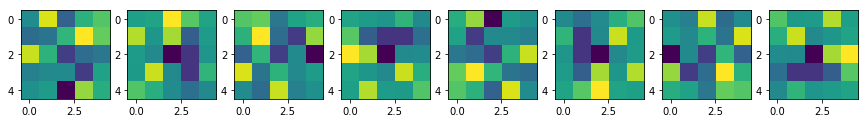

Rotated versions of the lifting kernels


In [11]:
plt.subplots(1,Ntheta,figsize=(15,15))
for i in range(Ntheta):
    plt.subplot(1,Ntheta,i+1)
    plt.imshow(lifting_k[i,:,:,0,0])
plt.show()
plt.subplots(1,Ntheta,figsize=(15,15))
for i in range(Ntheta):
    plt.subplot(1,Ntheta,i+1)
    plt.imshow(lifting_k[i,:,:,1,0])
plt.show()
print( 'Rotated versions of the lifting kernels')

### The rotate gconv kernels

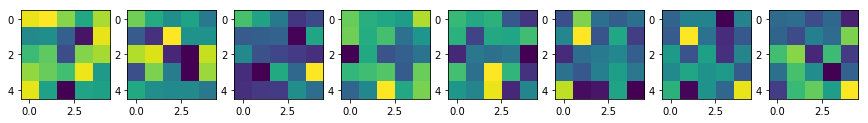

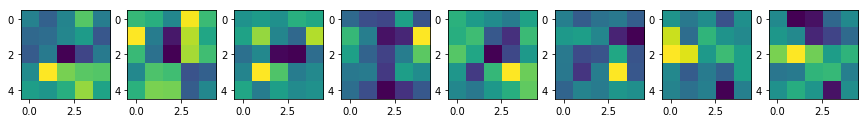

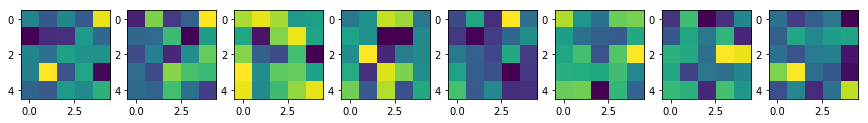

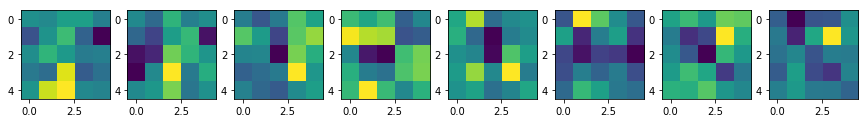

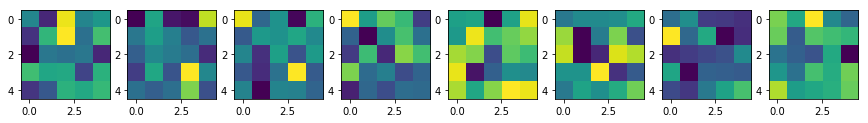

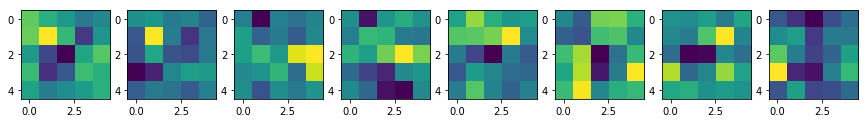

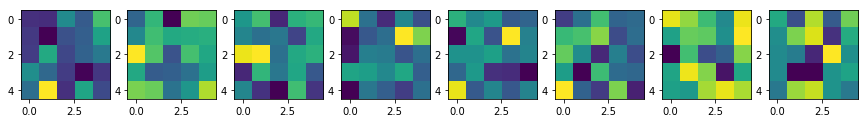

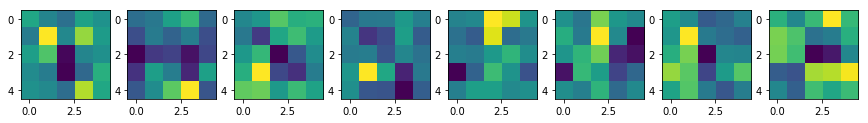

Each row is a rotated version of an se2 kernel (planar rotation + shift in theta direction)


In [12]:
for rot in range(Ntheta):
    plt.show()
    plt.subplots(1,Ntheta,figsize=(15,15))
    for i in range(Ntheta):
        plt.subplot(1,Ntheta,i+1)
        plt.imshow(gconv_k[rot,:,:,i,0,0])
    plt.show()
print( 'Each row is a rotated version of an se2 kernel (planar rotation + shift in theta direction)')

## Check covariance of the lifting layer

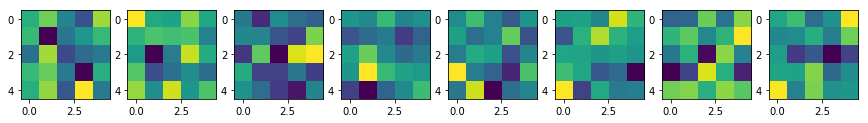

The unrotated input.


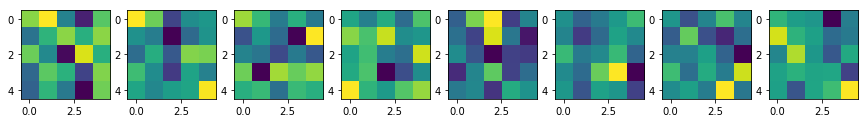

The 90-degree rotated input. Notice a shift of Ntheta/4 (=90/360*Ntheta) bins and a rotation of 90 of each plane.


In [13]:
#Plot
plt.subplots(1,Ntheta,figsize=(15,15))
for i in range(Ntheta):
    plt.subplot(1,Ntheta,i+1)
    plt.imshow(t_lifted[0,:,:,i,0])
plt.show()
print( 'The unrotated input.')
plt.subplots(1,Ntheta,figsize=(15,15))
for i in range(Ntheta):
    plt.subplot(1,Ntheta,i+1)
    plt.imshow(t_lifted_90[0,:,:,i,0])
plt.show()
print( 'The 90-degree rotated input. Notice a shift of Ntheta/4 (=90/360*Ntheta) bins and a rotation of 90 of each plane.')

## Check covariance down to the output of the group convolution layer

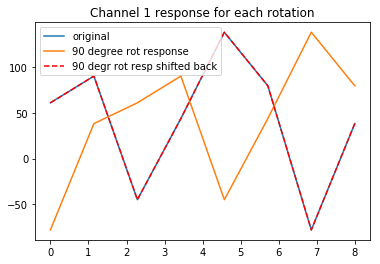

In [14]:
# Simple data to display in various forms
#x = np.linspace(0, 2 * np.pi, Ntheta)
x = np.linspace(0, Ntheta, Ntheta)
y = t_lifted_2[0,0,0,:,1]
y_90 = t_lifted_2_90[0,0,0,:,1]
y_90_back = np.roll(t_lifted_2_90[0,0,0,:,1],-int(Ntheta/4))
plt.figure()
plt.plot(x, y, label='original')
plt.plot(x, y_90, label='90 degree rot response')
plt.plot(x, y_90_back,'r--', label='90 degr rot resp shifted back')
plt.title('Channel 1 response for each rotation')
plt.legend()
plt.show()